# N-Gram, RNN and LSTM Language Models

## Load dataset

In [1]:
def load_corpus(filepath: str):
    with open(filepath, "r") as f:
        lines = f.readlines()
    return [line.strip().lower().split() for line in lines]

dir_root = "/home/leo/LLM_HW1/"

training_corpus = load_corpus(dir_root + "train.txt")

## Build N-gram Language Model Class

In [ ]:
import numpy as np
from collections import defaultdict
import random

class NGramLanguageModel:
    def __init__(self, n, smoothing=0.01):
        """
        Initialize N-gram language model
        Args:
            n: The value of n for n-grams (2 for bigram, 3 for trigram)
            smoothing: Smoothing parameter (Laplace/add-k smoothing)
        """
        self.n = n
        self.smoothing = smoothing
        self.n_gram_counts = None
        self.n_minus_1_gram_counts = None
        self.vocab = set()
    
    def n_gram_distribution(self, tokenized_corpus, n=2):

        if n < 2:
            raise ValueError("n must be larger than 1")

        n_minus_1_gram_counts = defaultdict(int)
        n_gram_counts = defaultdict(int)

        for sentence in tokenized_corpus:
            if len(sentence) < n:
                continue
            
            for i in range(len(sentence) - n + 1):
                n_gram = tuple(sentence[i : i + n])
                n_minus_1_gram = tuple(sentence[i : i + n - 1])
                
                n_minus_1_gram_counts[n_minus_1_gram] += 1
                n_gram_counts[n_gram] += 1
                
        return n_minus_1_gram_counts, n_gram_counts

    def train(self, tokenized_corpus):
        """Train the n-gram model on a tokenized corpus"""
        print(f"Training {self.n}-gram model...")
        
        # Get n-gram counts
        self.n_minus_1_gram_counts, self.n_gram_counts = self.n_gram_distribution(
            tokenized_corpus, self.n
        )
        
        # Build vocabulary
        for sentence in tokenized_corpus:
            self.vocab.update(sentence)
        
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"{self.n-1}-gram types: {len(self.n_minus_1_gram_counts)}")
        print(f"{self.n}-gram types: {len(self.n_gram_counts)}")
        
    def get_probability(self, n_gram):
        """
        Calculate the probability of an n-gram with smoothing
        P(wn | w1...wn-1) = (count(w1...wn) + smoothing) / (count(w1...wn-1) + smoothing * V)
        """
        if len(n_gram) != self.n:
            raise ValueError(f"Expected {self.n}-gram, got {len(n_gram)}-gram")
        
        context = tuple(n_gram[:-1])  # n-1 gram (context)
        
        numerator = self.n_gram_counts.get(tuple(n_gram), 0) + self.smoothing
        denominator = self.n_minus_1_gram_counts.get(context, 0) + self.smoothing * len(self.vocab)
        
        return numerator / denominator
    
    def predict_next_word(self, context, top_k=5):
        """
        Predict the most likely next word given a context
        Args:
            context: tuple of n-1 words
            top_k: return top k predictions
        Returns:
            List of (word, probability) tuples
        """
        if len(context) != self.n - 1:
            raise ValueError(f"Context should have {self.n-1} words")
        
        context = tuple(context)
        candidates = []
        
        # Find all n-grams that start with this context
        for n_gram, count in self.n_gram_counts.items():
            if n_gram[:-1] == context:
                word = n_gram[-1]
                prob = self.get_probability(n_gram)
                candidates.append((word, prob))
        
        # Sort by probability
        candidates.sort(key=lambda x: x[1], reverse=True)
        
        return candidates[:top_k]
    
    def generate_sentence(self, start_words, max_length=20):
        """
        Generate a sentence starting with given words
        Args:
            start_words: List of starting words (should be n-1 words)
            max_length: Maximum length of generated sentence
            sampling: If True, sample from distribution; if False, take most likely
        Returns:
            Generated sentence as a list of words
        """
        if len(start_words) < self.n - 1:
            raise ValueError(f"Need at least {self.n-1} starting words")
        
        sentence = list(start_words)
        
        while len(sentence) < max_length:
            context = tuple(sentence[-(self.n-1):])
            candidates = self.predict_next_word(context, top_k=1)
            
            if not candidates:
                # No predictions available, stop
                break
            
            # Take the most likely word
            next_word = candidates[0][0]
            
            sentence.append(next_word)
        
        return sentence

## (a) Train Models and Evaluate on Test Set

### Load test dataset

In [3]:
test_corpus = load_corpus(dir_root + "test.txt")
print(f"Test corpus size: {len(test_corpus)} sentences")
print(f"First 3 test sentences: {test_corpus[:3]}")

Test corpus size: 649918 sentences
First 3 test sentences: [['test', 'for', 'doneness'], ['add', 'cabbage', 'and', 'carrots'], ['add', 'onion', 'and', 'cook', 'until', 'golden', 'brown']]


### Train Bigram Model (n=2)

In [4]:
import time

print("=" * 60)
print("BIGRAM MODEL (n=2)")
print("=" * 60)

bigram_model = NGramLanguageModel(n=2, smoothing=0.01)

start_time = time.time()
bigram_model.train(training_corpus)
train_time = time.time() - start_time

print(f"\nTraining time: {train_time:.2f} seconds")

BIGRAM MODEL (n=2)
Training 2-gram model...
Vocabulary size: 63069
1-gram types: 55827
2-gram types: 707454

Training time: 14.03 seconds
Vocabulary size: 63069
1-gram types: 55827
2-gram types: 707454

Training time: 14.03 seconds


### Train Trigram Model (n=3)

In [5]:
print("\n" + "=" * 60)
print("TRIGRAM MODEL (n=3)")
print("=" * 60)

trigram_model = NGramLanguageModel(n=3, smoothing=0.01)

start_time = time.time()
trigram_model.train(training_corpus)
train_time = time.time() - start_time

print(f"\nTraining time: {train_time:.2f} seconds")


TRIGRAM MODEL (n=3)
Training 3-gram model...
Vocabulary size: 63069
2-gram types: 622841
3-gram types: 2353735

Training time: 17.55 seconds
Vocabulary size: 63069
2-gram types: 622841
3-gram types: 2353735

Training time: 17.55 seconds


### Evaluate Models on Test Set

In [6]:
def calculate_test_accuracy(model, test_corpus):
    """
    Calculate prediction accuracy on test set
    For each n-gram in test sentences, predict the next word and check if it matches
    """
    correct_predictions = 0
    total_predictions = 0
    
    for sentence in test_corpus:
        if len(sentence) < model.n:
            continue
        
        for i in range(len(sentence) - model.n + 1):
            # Get context and actual next word
            context = tuple(sentence[i : i + model.n - 1])
            actual_word = sentence[i + model.n - 1]
            
            # Predict next word
            candidates = model.predict_next_word(context, top_k=1)
            
            if candidates:
                predicted_word = candidates[0][0]
                if predicted_word == actual_word:
                    correct_predictions += 1
            
            total_predictions += 1
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy, correct_predictions, total_predictions

# Evaluate Bigram Model
print("=" * 60)
print("EVALUATING BIGRAM MODEL ON TEST SET")
print("=" * 60)

bigram_accuracy, bigram_correct, bigram_total = calculate_test_accuracy(bigram_model, test_corpus)
print(f"\nBigram Model Results:")
print(f"  Correct Predictions: {bigram_correct} / {bigram_total}")
print(f"  Accuracy: {bigram_accuracy * 100:.2f}%")

EVALUATING BIGRAM MODEL ON TEST SET


KeyboardInterrupt: 

In [ ]:
# Evaluate Trigram Model
print("\n" + "=" * 60)
print("EVALUATING TRIGRAM MODEL ON TEST SET")
print("=" * 60)

trigram_accuracy, trigram_correct, trigram_total = calculate_test_accuracy(trigram_model, test_corpus)
print(f"\nTrigram Model Results:")
print(f"  Correct Predictions: {trigram_correct} / {trigram_total}")
print(f"  Accuracy: {trigram_accuracy * 100:.2f}%")

In [ ]:
# Compare Model Performance
print("\n" + "=" * 60)
print("MODEL COMPARISON ON TEST SET")
print("=" * 60)

print(f"\nAccuracy Comparison:")
print(f"  Bigram Model:  {bigram_accuracy * 100:.2f}%")
print(f"  Trigram Model: {trigram_accuracy * 100:.2f}%")

improvement = (trigram_accuracy - bigram_accuracy) * 100
print(f"\nAccuracy Improvement: {improvement:+.2f}%")

if trigram_accuracy > bigram_accuracy:
    print(f"Trigram model performs better (higher accuracy)")
elif trigram_accuracy < bigram_accuracy:
    print(f"Bigram model performs better (may be due to data sparsity)")
else:
    print(f"= Both models have the same accuracy")

## (b) Hardware Usage Monitoring

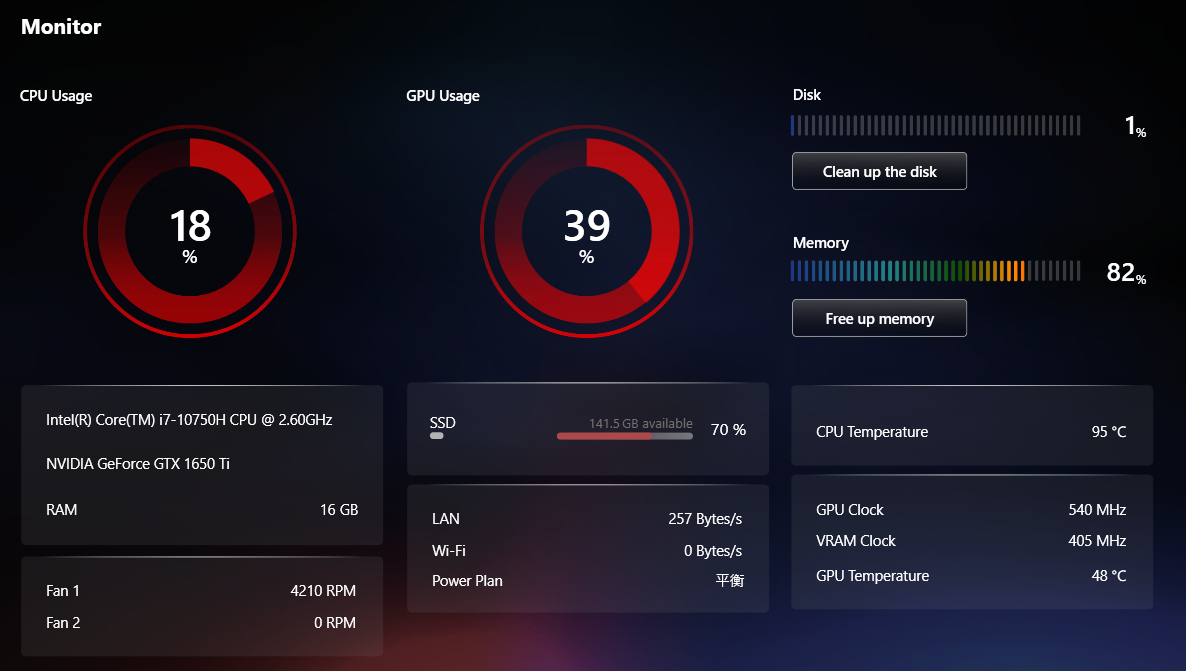

## (c) Sentence Completion with Trigram Model

In [ ]:
# Load incomplete sentences
incomplete_sentences = load_corpus(dir_root + "incomplete.txt")

print(f"Number of incomplete sentences: {len(incomplete_sentences)}")
print(f"\nIncomplete sentences:")
for i, sent in enumerate(incomplete_sentences, 1):
    print(f"{i}. {' '.join(sent)}")

Number of incomplete sentences: 10

Incomplete sentences:
1. cover with
2. roll up
3. cook the
4. stir in
5. spread out
6. transfer the
7. put the
8. push the
9. cut into
10. toss the


In [ ]:
# Complete sentences using the trigram model
print(f"\n{'='*80}")
print("SENTENCE COMPLETION USING TRIGRAM MODEL")
print(f"{'='*80}\n")

completed_sentences = []

for i, incomplete in enumerate(incomplete_sentences, 1):
    print(f"Sentence {i}:")
    print(f"  Incomplete: {' '.join(incomplete)}")
    
    # Generate completion
    completed = trigram_model.generate_sentence(incomplete, max_length=20, sampling=True)
    completed_sentences.append(completed)
    
    print(f"  Completed:  {' '.join(completed)}")
    print(f"  Length: {len(completed)} words\n")


SENTENCE COMPLETION USING TRIGRAM MODEL

Sentence 1:
  Incomplete: cover with
  Completed:  cover with plastic wrap on the stove top on the outside and a little bit at a time and stir
  Length: 20 words

Sentence 2:
  Incomplete: roll up
  Completed:  cover with plastic wrap on the stove top on the outside and a little bit at a time and stir
  Length: 20 words

Sentence 2:
  Incomplete: roll up
  Completed:  roll up tightly from the refrigerator and let rise for 1 minute more or until a tester comes out clean
  Length: 20 words

Sentence 3:
  Incomplete: cook the
  Completed:  roll up tightly from the refrigerator and let rise for 1 minute more or until a tester comes out clean
  Length: 20 words

Sentence 3:
  Incomplete: cook the
  Completed:  cook the potatoes in bottom of each of 6 bowls and top with whipped cream over the top of the
  Length: 20 words

Sentence 4:
  Incomplete: stir in
  Completed:  cook the potatoes in bottom of each of 6 bowls and top with whipped cream over th